## Script for comparion of inversion estimates from linear MB gradients from OGGM and MB observations
 uses a custom polygon instead of preprocessed directories to avoid geometry issues for certain glaciers
 like Nordic and Conrad

In [1]:
%matplotlib inline
import numpy as np
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import oggm
from oggm import cfg, utils, workflow, tasks, graphics
cfg.initialize(logging_level='WORKFLOW')

2019-08-02 14:30:32: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/oggm/oggm/params.cfg


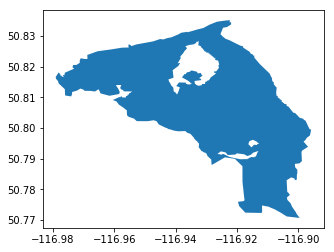

In [3]:
entity = utils.get_rgi_glacier_entities(['RGI60-02.02171'])
entity.plot();

In [5]:
glacier = ['Kokanee', 'Haig', 'Conrad', 'W.Washmawapta', 'Illecillewaet', 'Nordic', 'Zillmer']
num = 2 #num determines which gdir and gradient to use, refer to list below to select desired site

cfg.PARAMS['use_rgi_area'] = False
cfg.PATHS['working_dir'] = utils.get_temp_dir(glacier[num] + '_grad')
cfg.PARAMS['use_intersects'] = False

In [6]:
# make a working directory for this DEM 
gdir = workflow.init_glacier_regions(entity)[0]
grad = [5.8, 9.8, 5.9, 9.8, 7.5, 5.3, 5.8]

2019-08-02 14:31:13: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers
2019-08-02 14:31:13: oggm.workflow: Multiprocessing: using all available processors (N=8)
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


In [7]:
gdir

<oggm.GlacierDirectory>
  RGI id: RGI60-02.02171
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 16.884 km2
  Lon, Lat: (-116.93, 50.8069)
  Grid (nx, ny): (126, 145)
  Grid (dx, dy): (68.0, -68.0)

Note area has been calculated based on my custom polygon

In [8]:
list_talks = [
         tasks.glacier_masks,
         tasks.compute_centerlines,
         tasks.initialize_flowlines,
         tasks.catchment_area,
         tasks.catchment_width_geom,
         tasks.catchment_width_correction,
         tasks.compute_downstream_line,
         tasks.compute_downstream_bedshape
         ]
for task in list_talks:
    workflow.execute_entity_task(task, gdir)

2019-08-02 14:31:17: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-08-02 14:31:18: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-08-02 14:31:18: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-08-02 14:31:18: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-08-02 14:31:19: oggm.workflow: Execute entity task catchment_width_geom on 1 glaciers
2019-08-02 14:31:19: oggm.workflow: Execute entity task catchment_width_correction on 1 glaciers
2019-08-02 14:31:19: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-08-02 14:31:19: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers


In [9]:
workflow.execute_entity_task(tasks.process_cru_data, gdir);

2019-08-02 14:31:21: oggm.workflow: Execute entity task process_cru_data on 1 glaciers


In [10]:
fpath = gdir.get_filepath('climate_monthly')

In [11]:
workflow.execute_entity_task(tasks.local_t_star, gdir);
workflow.execute_entity_task(tasks.mu_star_calibration, gdir);

2019-08-02 14:31:22: oggm.workflow: Execute entity task local_t_star on 1 glaciers
2019-08-02 14:31:22: oggm.workflow: Execute entity task mu_star_calibration on 1 glaciers


In [12]:
from oggm.core.massbalance import ConstantMassBalance, MultipleFlowlineMassBalance
mb_mod = MultipleFlowlineMassBalance(gdir, use_inversion_flowlines=True, mb_model_class=ConstantMassBalance)
z, w, mb_on_z = mb_mod.get_annual_mb_on_flowlines()
mb_on_z *=  cfg.PARAMS['ice_density'] * cfg.SEC_IN_YEAR

In [13]:
#Computing the ice thickness (Inversion)
list_talks = [
         tasks.prepare_for_inversion,  # This is a preprocessing task
         tasks.mass_conservation_inversion,  # This does the actual job
         tasks.filter_inversion_output  # This smoothes the thicknesses at the tongue a little
         ]
for task in list_talks:
    workflow.execute_entity_task(task, gdir)

2019-08-02 14:31:23: oggm.workflow: Execute entity task prepare_for_inversion on 1 glaciers
2019-08-02 14:31:23: oggm.workflow: Execute entity task mass_conservation_inversion on 1 glaciers
2019-08-02 14:31:23: oggm.workflow: Execute entity task filter_inversion_output on 1 glaciers


In [14]:
# grad_line = np.polyfit(mb_on_z,z,2)
from scipy import stats 
slope, intercept, r_value, p_value, std_err = stats.linregress(mb_on_z, z)
print("slope: %f    intercept: %f" % (slope, intercept), "  R-squared: %f" % r_value**2)

slope: 0.237335    intercept: 2623.584148   R-squared: 0.991000


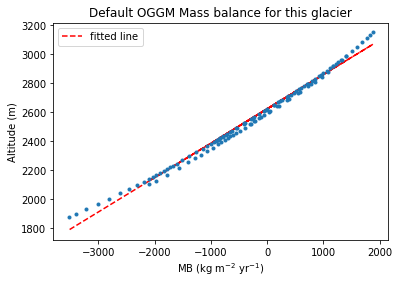

In [15]:
plt.plot(mb_on_z, intercept + slope*mb_on_z, 'r--', label='fitted line');
plt.plot(mb_on_z, z, '.');
plt.title('Default OGGM Mass balance for this glacier');
plt.xlabel('MB (kg m$^{-2}$ yr$^{-1}$)');
plt.ylabel('Altitude (m)');
plt.legend();

In [16]:
# See the result of the inversion
workflow.execute_entity_task(tasks.distribute_thickness_per_altitude, gdir);

2019-08-02 14:31:24: oggm.workflow: Execute entity task distribute_thickness_per_altitude on 1 glaciers


In [17]:
import xarray as xr
ds_default = xr.open_dataset(gdir.get_filepath('gridded_data')).load()
ds_default.close() # I have the strange feeling that xarray sometimes won't re-read overwitten files (and we will overwrite it later)

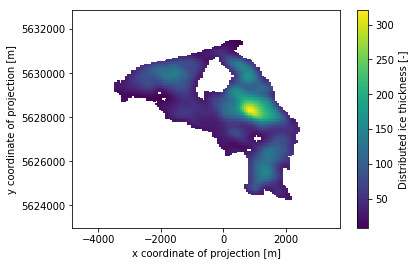

In [18]:
ds_default.distributed_thickness.plot();

In [19]:
# Let's apply a linear MB instead
from oggm.core.climate import apparent_mb_from_linear_mb

workflow.execute_entity_task(tasks.apparent_mb_from_linear_mb, gdir, mb_gradient=grad[num]);

2019-08-02 14:31:25: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers


In [20]:
# Compare what we got from this
from oggm.core.massbalance import LinearMassBalance

params = gdir.read_pickle('linear_mb_params')
print(params)

l_mb_mod = LinearMassBalance(params['ela_h'], grad=params['grad'])
l_mb_on_z = l_mb_mod.get_annual_mb(z) * cfg.PARAMS['ice_density'] * cfg.SEC_IN_YEAR

{'ela_h': 2547.74663912496, 'grad': 5.9}


In [21]:
slope, intercept, r_value, p_value, std_err = stats.linregress(mb_on_z, z)
print("slope default: %f    intercept: %f" % (slope, intercept), "  R-squared: %f" % r_value**2)
slope, intercept, r_value, p_value, std_err = stats.linregress(l_mb_on_z, z)
print("slope: %f    intercept: %f" % (slope, intercept), "  R-squared: %f" % r_value**2)

slope default: 0.237335    intercept: 2623.584148   R-squared: 0.991000
slope: 0.169492    intercept: 2547.746639   R-squared: 1.000000


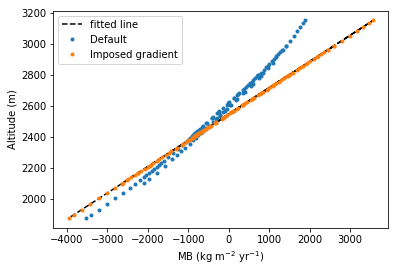

In [22]:
plt.plot(l_mb_on_z, intercept + slope*l_mb_on_z, 'k--', label='fitted line');
plt.plot(mb_on_z, z, '.', label='Default');
plt.plot(l_mb_on_z, z, '.', label='Imposed gradient');
plt.xlabel('MB (kg m$^{-2}$ yr$^{-1}$)');
plt.ylabel('Altitude (m)');
plt.legend();

In [23]:
# Now let's recompute the inversion based on this new gradient
workflow.execute_entity_task(tasks.prepare_for_inversion, gdir)
workflow.execute_entity_task(tasks.mass_conservation_inversion, gdir)
workflow.execute_entity_task(tasks.filter_inversion_output, gdir) # unfortunately...
workflow.execute_entity_task(tasks.distribute_thickness_per_altitude, gdir);

2019-08-02 14:31:26: oggm.workflow: Execute entity task prepare_for_inversion on 1 glaciers
2019-08-02 14:31:26: oggm.workflow: Execute entity task mass_conservation_inversion on 1 glaciers
2019-08-02 14:31:26: oggm.workflow: Execute entity task filter_inversion_output on 1 glaciers
2019-08-02 14:31:26: oggm.workflow: Execute entity task distribute_thickness_per_altitude on 1 glaciers


In [24]:
ds_new = xr.open_dataset(gdir.get_filepath('gridded_data')).load()
ds_new.close() 

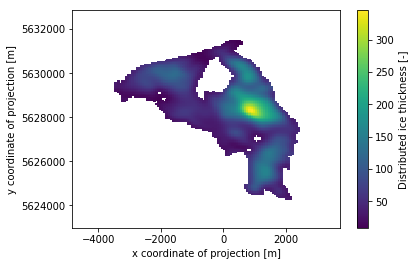

In [25]:
ds_new.distributed_thickness.plot();

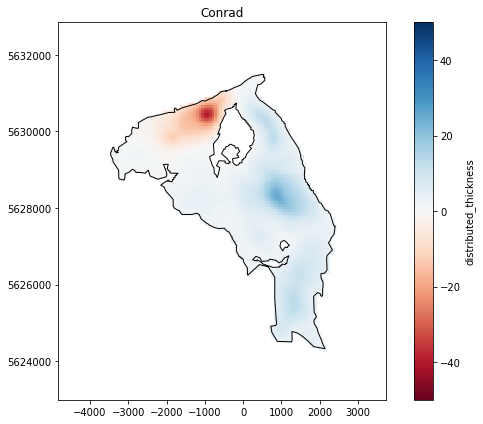

In [26]:
f, ax = plt.subplots(figsize=(8,6))
(ds_new - ds_default).distributed_thickness.plot(ax=ax, cmap='RdBu', vmin =-50, vmax=50); #'RdBu'
plt.ylabel('')
plt.xlabel('')
plt.title(glacier[num])
gdir.read_shapefile('outlines').plot(ax=ax, color='none', edgecolor='black');
plt.tight_layout()
# plt.savefig('/home/pelto/Desktop/ice_thick/' + glacier[num] + '_mb_grad_diff.png', dpi=600)

In [27]:
print(np.mean(ds_new.distributed_thickness))
print(ds_default.distributed_thickness.mean())

<xarray.DataArray 'distributed_thickness' ()>
array(82.07791, dtype=float32)
<xarray.DataArray 'distributed_thickness' ()>
array(78.817276, dtype=float32)


In [28]:
print(cfg.PARAMS['inversion_glen_a']) ## Glen's creep parameter for the thickness inversion physics
print(cfg.PARAMS['inversion_fs']) ## ## Oerlemans "sliding" factor For the thickness inversion physics
print(cfg.PARAMS['use_shape_factor_for_inversion']) # Allowed is empty, "Adhikari", "Nye" (equivalent to "Adhikari") or "Huss"
print(cfg.PARAMS['default_parabolic_bedshape'])

2.4e-24
0.0

0.003
